# Import Libraries 

In [54]:
# Deep Learning Functionalities

import tensorflow as tf


import os,glob
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras import regularizers
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow.keras import layers

from sklearn.model_selection import KFold

import pandas as pd 
import seaborn as sns

In [55]:
# Loading the training dataset directory 
DATADIRTRAIN = '/Users/kirti/Desktop/MSCI446/train'

# Loading the testing dataset directory 
DATADIRVAL = '/Users/kirti/Desktop/MSCI446/val'

In [56]:
import pathlib
data_dir_train = pathlib.Path(DATADIRTRAIN)
data_dir_val = pathlib.Path(DATADIRVAL)

In [57]:
# Number of images in the training data 

# glob module --> counts the number of PNG images 
image_count_png = len(list(data_dir_train.glob('*/*.png')))
image_count_jpg = len(list(data_dir_train.glob('*/*.jpg')))

# Number of images in the testing data 
image_count_2_png = len(list(data_dir_val.glob('*/*.png')))
image_count_2_jpg = len(list(data_dir_val.glob('*/*.jpg')))

# Printing the image count
print("Training Image Set PNG: ", image_count_png)
print("Training Image Set JPG: ", image_count_jpg)

print("Validation Image Set PNG: ", image_count_2_png)
print("Validation Image Set JPG: ", image_count_2_jpg)


Training Image Set PNG:  7352
Training Image Set JPG:  764
Validation Image Set PNG:  806
Validation Image Set JPG:  94


# Data Cleaning

In [58]:
# Establishing batch size and image sizes 

batch_size=32
img_height=180
img_width=180

In [59]:
# Load the training data as a TensorFlow dataset

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2, # within training, there is a validation set of 20% 
    subset="training",
    seed=123,
    image_size=(img_height, img_width), # change the image sizes 
    batch_size=batch_size) # batches of 32 images 

Found 8116 files belonging to 2 classes.
Using 6493 files for training.


In [60]:
# Load the testing data as a TensorFlow dataset

test_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_val,
    validation_split=0.2, # within training, there is a validation set of 20% 
    subset="validation",
    seed=123,
    image_size=(img_height, img_width), # change the image sizes 
    batch_size=batch_size) # batches of 32 images 

Found 900 files belonging to 2 classes.
Using 180 files for validation.


In [61]:
# Training set

class_names = train_ds.class_names
print(class_names)

['benign', 'malignant']


In [62]:
# Testing set

class_names = test_ds.class_names
print(class_names)

['benign', 'malignant']


2024-03-24 19:19:28.449115: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


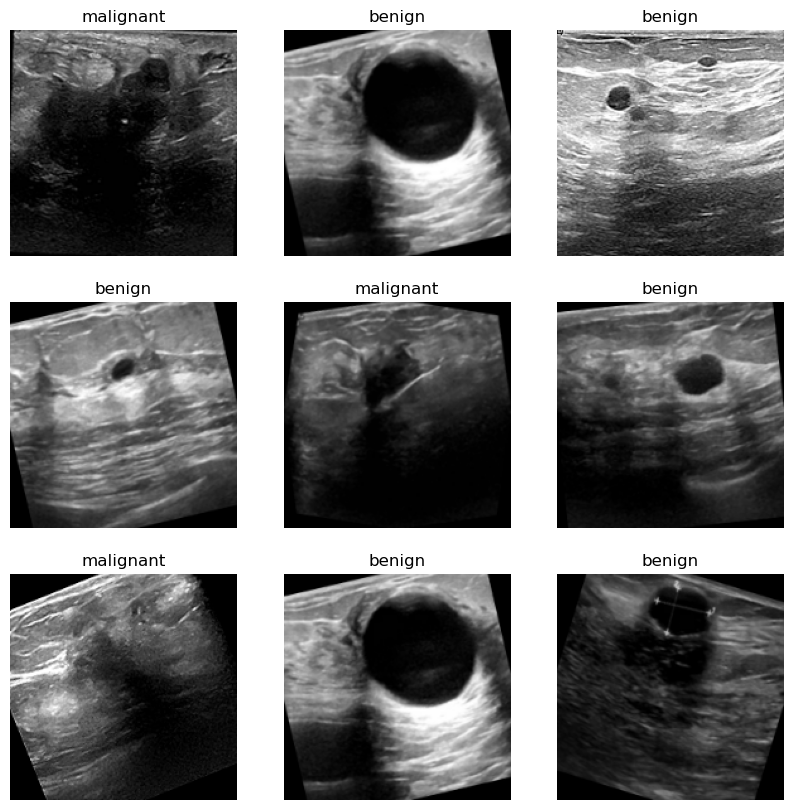

In [63]:
import matplotlib.pyplot as plt

# Viewing the images from the dataset 
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [64]:
AUTOTUNE = tf.data.AUTOTUNE

# Cache, shuffle, prefetch the datasets for better preformance 

# Cache --> process of storing data in memory so it can be accessed more quickly 
# Shuffle --> shuffles the elements of the dataset randomly
# Prefetch --> where the data required for the next step in a process is fetched and prepared in advance

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Model Formation

In [68]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler

# Define early stopping callback to stop training if validation loss doesn't improve for a certain number of epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Define learning rate reduction callback to reduce learning rate if validation loss plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)

# Building the CNN model with added Dropout layers for regularization
model = Sequential([
    Conv2D(32, 3, padding='same', activation='relu', input_shape=(img_height, img_width, 3), kernel_regularizer=regularizers.l2(0.1)),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.1)),
    MaxPooling2D(),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.1)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Data Evaluation

In [69]:
# Test the 10 epochs 
epochs = 20


# Fitting the model to the train and test data 
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=epochs,
    callbacks=[early_stopping, reduce_lr])

model.summary()

Epoch 1/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 246s 1s/step - accuracy: 0.5519 - loss: 71.8798 - val_accuracy: 0.4111 - val_loss: 10.4781 - learning_rate: 0.0010
Epoch 2/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 231s 1s/step - accuracy: 0.5918 - loss: 9.8555 - val_accuracy: 0.4611 - val_loss: 8.5563 - learning_rate: 0.0010
Epoch 3/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 203s 996ms/step - accuracy: 0.5969 - loss: 8.1969 - val_accuracy: 0.7000 - val_loss: 7.3631 - learning_rate: 0.0010
Epoch 4/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 198s 975ms/step - accuracy: 0.6760 - loss: 7.0757 - val_accuracy: 0.4889 - val_loss: 6.5420 - learning_rate: 0.0010
Epoch 5/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 215s 1s/step - accuracy: 0.7140 - loss: 6.1547 - val_accuracy: 0.5889 - val_loss: 5.7673 - learning_rate: 0.0010
Epoch 6/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 192s 942ms/step - accuracy: 0.7935 - loss: 5.2960 - val_accuracy: 0.6333 - val_loss: 5.0450 - learning_rate: 0.0010
Epoch 7/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 193s 950ms/step - accuracy: 0.8

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 90, 90, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 129600)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │    33,177,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 99,690,821 (380.29 MB)

 Trainable params: 33,230,273 (126.76 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 66,460,548 (253.53 MB)

# Graphs

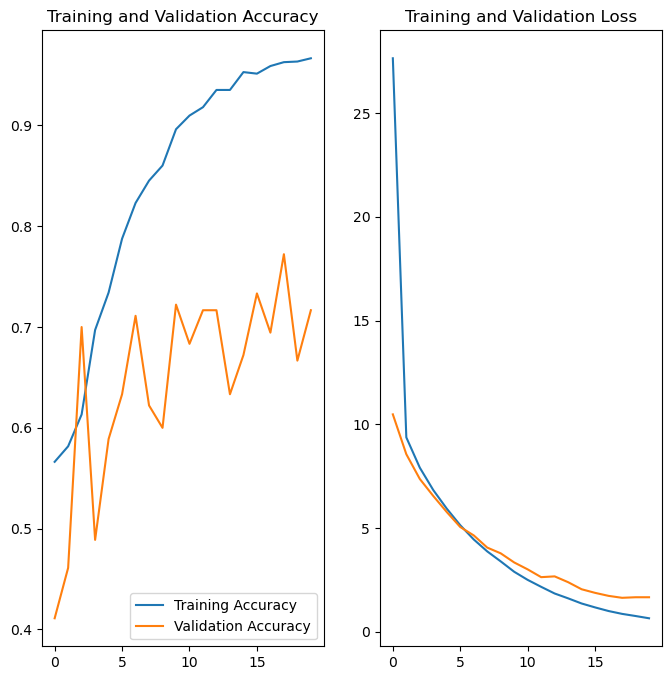

In [71]:
# measure the accuracy of the models 
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# measure the loss of the models 
loss = history.history['loss']
val_loss = history.history['val_loss']


# use the best epoch from the previous results 
epochs = 20
epochs_range = range(epochs)


plt.figure(figsize=(8, 8))

# Plotting the accuracy and loss of the model 
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss') 
plt.title('Training and Validation Loss')

plt.show()
